In [1]:
import sympy
import symnum
import symnum.numpy as snp
import simsde
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import cho_solve
from jax import jit, vmap
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

## Model functions

In [2]:
def drift_func_rough(x, θ):
    A, B, a, b, C, ν_max, v_0, r, μ_0, μ_1, μ_2, *_ = θ
    C_1 = C
    C_2 = 0.8 * C
    C_3 = C_4 = 0.25 * C
    sigmoid = lambda y: ν_max / (1 + snp.exp(r * (v_0 - y)))
    return snp.array([
        A * a * (μ_0 + sigmoid(x[4] - x[5])) - 2 * a * x[0] - a**2 * x[3],
        A * a * (μ_1 + C_2 * sigmoid(C_1 * x[3])) - 2 * a * x[1] - a**2 * x[4],
        B * b * (μ_2 + C_4 * sigmoid(C_3 * x[3])) - 2 * b * x[2] - b**2 * x[5],
    ])  

def drift_func_smooth(x, θ):
    return x[:3]  

def diff_coeff_rough(x, θ):
    *_, σ_0, σ_1, σ_2 = θ
    return snp.array([[σ_0, 0, 0], [0, σ_1, 0], [0, 0, σ_2]])

def drift_func(x, θ):
    return snp.concatenate((drift_func_rough(x, θ), drift_func_smooth(x, θ)))

def diff_coeff(x, θ):
    return snp.concatenate((diff_coeff_rough(x, θ), snp.zeros((dim_x - dim_r, dim_w))), 0)

dim_x = 6
dim_r = 3
dim_w = 3
dim_θ = 14

## Simulating paths

In [3]:
use_euler_maruyama = False
if use_euler_maruyama:
    dim_n = dim_r
    step_func = simsde.integrators.euler_maruyama_step(drift_func, diff_coeff)
else:
    dim_n = 4 * dim_r - 1
    step_func = simsde.integrators.hypoelliptic_weak_order_2_step(drift_func_rough, drift_func_smooth, diff_coeff_rough)
jax_step_func = symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)

In [4]:
@jit
def simulate_diffusion(x_0, θ, t_seq, n_seq):
    
    def step_func(x, n_dt):
        n, dt = n_dt
        x_next = jax_step_func(x, θ, n, dt)
        return x_next, x_next
    
    _, x_seq = scan(step_func, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
    
    return jnp.concatenate((x_0[None], x_seq))

vmapped_simulate_diffusion = jit(vmap(simulate_diffusion, (None, None, None, 0)))

In [5]:
rng = np.random.default_rng(1234)
dt = 0.002
t_max = 2.
t_seq = np.arange(int(t_max / dt)) * dt
x_0 = np.array([-0.5, 0, 0, 0.08, 18, 15])
parameter_values = {
    "A": 3.25, 
    "B": 22, 
    "a": 100, 
    "b": 50, 
    "C": 135., 
    "ν_max": 5, 
    "v_0": 6, 
    "r": 0.56, 
    "μ_0": 0., 
    "μ_1": 220., 
    "μ_2": 0., 
    "σ_0": 0.01, 
    "σ_1": 2000., 
    "σ_2": 1.,
}
θ = np.array(list(parameter_values.values()))

n_seqs = rng.standard_normal((10, t_seq.shape[0] - 1, dim_n))
x_seqs = vmapped_simulate_diffusion(x_0, θ, t_seq, n_seqs)

Text(0.5, 0, 'Time')

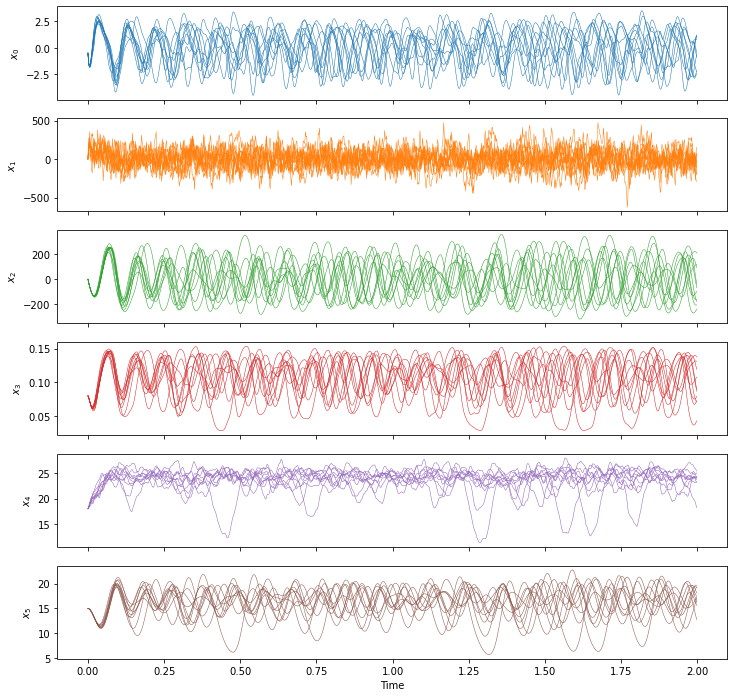

In [6]:
fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = [f'$x_{i}$' for i in range(dim_x)]
for i, ax in enumerate(axes):
    ax.plot(t_seq, x_seqs[:, :, i].T, color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel('Time')

Text(0.5, 0, 'Time')

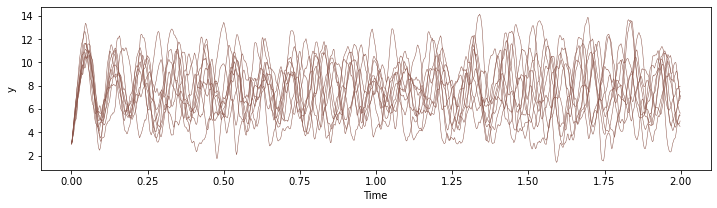

In [7]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t_seq, (x_seqs[:, :, 4] - x_seqs[:, :, 5]).T, color=f'C{i}', lw=0.5)
ax.set_ylabel("y")
ax.set_xlabel('Time')

## Local Gaussian approximate transition density

In [8]:
mean_and_covar_symbolic = simsde.densities.local_gaussian_mean_and_covariance(
    drift_func_rough, drift_func_smooth, diff_coeff_rough
)

In [9]:
μ, Σ = mean_and_covar_symbolic(
    snp.array(sympy.symbols('x:6')), 
    snp.array(sympy.symbols('A B a b C ν_max v_0 r μ_0 μ_1 μ_2 σ_0 σ_1 σ_2')), 
    symnum.named_array('t', ())
)
display(μ)
display(Σ)

[t*(A*a*(μ_0 + ν_max/(exp(r*(v_0 - x4 + x5)) + 1)) - a**2*x3 - 2*a*x0) + x0, t*(A*a*(0.8*C*ν_max/(exp(r*(-C*x3 + v_0)) + 1) + μ_1) - a**2*x4 - 2*a*x1) + x1, t*(B*b*(0.25*C*ν_max/(exp(r*(-0.25*C*x3 + v_0)) + 1) + μ_2) - b**2*x5 - 2*b*x2) + x2, t**2*(A*a*(μ_0 + ν_max/(exp(r*(v_0 - x4 + x5)) + 1)) - a**2*x3 - 2*a*x0)/2 + t*x0 + x3, t**2*(A*a*(0.8*C*ν_max/(exp(r*(-C*x3 + v_0)) + 1) + μ_1) - a**2*x4 - 2*a*x1)/2 + t*x1 + x4, t**2*(B*b*(0.25*C*ν_max/(exp(r*(-0.25*C*x3 + v_0)) + 1) + μ_2) - b**2*x5 - 2*b*x2)/2 + t*x2 + x5]

[[t*σ_0**2, 0, 0, t**2*σ_0**2/2, 0, 0], [0, t*σ_1**2, 0, 0, t**2*σ_1**2/2, 0], [0, 0, t*σ_2**2, 0, 0, t**2*σ_2**2/2], [t**2*σ_0**2/2, 0, 0, t**3*σ_0**2/3, 0, 0], [0, t**2*σ_1**2/2, 0, 0, t**3*σ_1**2/3, 0], [0, 0, t**2*σ_2**2/2, 0, 0, t**3*σ_2**2/3]]

In [10]:
for eigenvalue in sympy.Matrix(Σ).eigenvals():
    display(eigenvalue)

t*σ_0**2*(t**2 + 3)/6 - t*σ_0**2*sqrt(t**4/9 + t**2/3 + 1)/2

t*σ_0**2*(t**2 + 3)/6 + t*σ_0**2*sqrt(t**4/9 + t**2/3 + 1)/2

t*σ_1**2*(t**2 + 3)/6 - t*σ_1**2*sqrt(t**4/9 + t**2/3 + 1)/2

t*σ_1**2*(t**2 + 3)/6 + t*σ_1**2*sqrt(t**4/9 + t**2/3 + 1)/2

t*σ_2**2*(t**2 + 3)/6 - t*σ_2**2*sqrt(t**4/9 + t**2/3 + 1)/2

t*σ_2**2*(t**2 + 3)/6 + t*σ_2**2*sqrt(t**4/9 + t**2/3 + 1)/2

In [11]:
mean_and_covar_jax = symnum.numpify(dim_x, dim_θ, (), numpy_module=jnp)(mean_and_covar_symbolic)

In [12]:
def log_transition_density(x_t, x_0, θ, t):
    dim_x = x_0.shape[0]
    μ, Σ = mean_and_covar_jax(x_0, θ, t)
    chol_Σ = jnp.linalg.cholesky(Σ)
    x_t_minus_μ = x_t - μ
    return -(
        x_t_minus_μ @ cho_solve((chol_Σ, True), x_t_minus_μ) / 2
        + jnp.log(chol_Σ.diagonal()).sum()
        + jnp.log(2 * jnp.pi) * (dim_x / 2)
    )

In [13]:
log_transition_density(x_seqs[0, 1, :], x_0, θ, dt)

DeviceArray(-89108.06325681, dtype=float64)